In [1]:
import torch
from torch.optim import Adam
import torch.nn.functional as F
from tqdm.auto import trange
import numpy as np
import matplotlib.pyplot as plt
from dgl.dataloading import GraphDataLoader
from pytorch_lightning.loggers import CSVLogger
from pytorch_lightning import Trainer
import pandas as pd

from gnncloudmanufacturing.data import read_fatahi_dataset
from gnncloudmanufacturing.mip_solver import mip_solve
from gnncloudmanufacturing.validation import total_cost_from_graph
from gnncloudmanufacturing.utils import GraphDataset, delta_from_gamma, graph_from_problem, gamma_from_target, os_type, ss_type, so_type
from gnncloudmanufacturing.graph_model import GNN

In [2]:
dataset = read_fatahi_dataset('../data/fatahi.xlsx')
len(dataset)

  0%|          | 0/18 [00:00<?, ?it/s]

18

In [3]:
train_problem = dataset[0]
val_problem = dataset[2]
train_problem['name'], val_problem['name']

('5,10,10-1', '5,10,10-3')

In [4]:
train_delta, train_gamma, status, value = mip_solve(train_problem)
print(f'Problem {train_problem["name"]}: {value:.2f}, {status}')

Problem 5,10,10-1: 5086.08, OptimizationStatus.OPTIMAL


In [5]:
val_delta, val_gamma, status, value = mip_solve(val_problem, max_seconds=5)
print(f'Problem {val_problem["name"]}: {value:.2f}, {status}')

Problem 5,10,10-3: 9875.80, OptimizationStatus.FEASIBLE


In [6]:
train_graph = graph_from_problem(train_problem, train_gamma)
train_graph.edata['feat'][os_type][:, 0] /= 10
train_graph.edata['feat'][ss_type][:] /= 100

val_graph = graph_from_problem(val_problem, val_gamma)
val_graph.edata['feat'][os_type][:, 0] /= 10
val_graph.edata['feat'][ss_type][:] /= 100

In [7]:
train_dataset = GraphDataset([train_graph])
val_dataset = GraphDataset([val_graph])

In [8]:
train_dataloader = GraphDataLoader(train_dataset, batch_size=1)
val_dataloader = GraphDataLoader(val_dataset, batch_size=1)

In [9]:
model = GNN(
    ins_dim=1,
    ino_dim=train_problem['n_operations']+2,
    out_dim=16,
    n_layers=1,
    lr=0.001,
)
model

GNN(
  (convs): ModuleList(
    (0): AttnConvLayer(
      (W_s): Linear(in_features=1, out_features=16, bias=True)
      (W_os): Linear(in_features=14, out_features=16, bias=True)
      (W_ss): Linear(in_features=2, out_features=16, bias=True)
      (attn): Linear(in_features=32, out_features=1, bias=True)
      (W_in): Linear(in_features=12, out_features=16, bias=True)
      (W_self): Linear(in_features=12, out_features=16, bias=True)
      (W_out): Linear(in_features=12, out_features=16, bias=True)
      (W_o): Linear(in_features=48, out_features=16, bias=True)
    )
  )
  (dec): DotProductDecoder()
)

In [10]:
trainer = Trainer(
    enable_progress_bar=True,
    max_epochs=1000,
    log_every_n_steps=1,
    logger=CSVLogger('.'),
)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [11]:
trainer.fit(
    model=model, 
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
)


  | Name  | Type              | Params | Mode 
----------------------------------------------------
0 | convs | ModuleList        | 1.8 K  | train
1 | dec   | DotProductDecoder | 0      | train
----------------------------------------------------
1.8 K     Trainable params
0         Non-trainable params
1.8 K     Total params
0.007     Total estimated model params size (MB)


Sanity Checking: |                                                                                 | 0/? [00:0…

C:\Users\pozdnyakov\AppData\Local\miniconda3\envs\gnn\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
C:\Users\pozdnyakov\AppData\Local\miniconda3\envs\gnn\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Training: |                                                                                        | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

Validation: |                                                                                      | 0/? [00:0…

`Trainer.fit` stopped: `max_epochs=1000` reached.


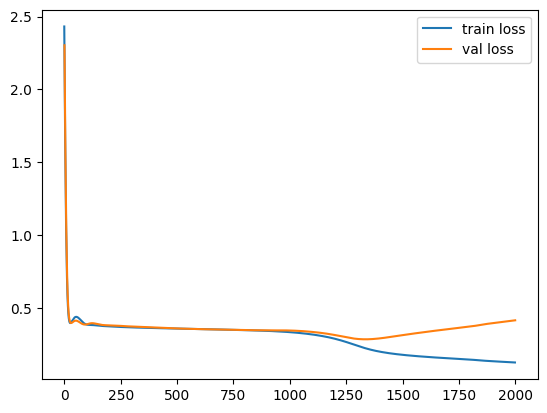

In [14]:
metrics = pd.read_csv(f'lightning_logs/version_{trainer.logger.version}/metrics.csv')
plt.plot(metrics.train_loss.dropna(), label='train loss')
plt.plot(metrics.val_loss.dropna(), label='val loss')
plt.legend()
plt.show()

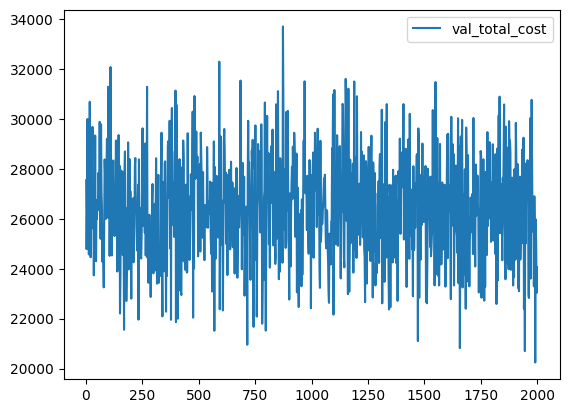

In [15]:
plt.plot(metrics.val_total_cost.dropna(), label='val_total_cost')
plt.legend()
plt.show()